<a href="https://colab.research.google.com/github/Aditya4628/Wikipedia_Analysis/blob/main/Big_Data_Project_Adi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gunzip '/content/drive/MyDrive/clickstream-enwiki-2017-11.tsv.gz'

gzip: /content/drive/MyDrive/clickstream-enwiki-2017-11.tsv.gz: No such file or directory


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/clickstream-enwiki-2017-11.tsv',sep='\t')

In [ ]:
pip install dask

In [ ]:
import dask.dataframe as dd
df = dd.read_csv('/content/drive/MyDrive/clickstream-enwiki-2017-11.tsv',sep='\t',header=None)

In [ ]:
column_names = ['referrer', 'requested_page', 'navigation_type', 'clicks']
df.columns = column_names
df.head()

,referrer,requested_page,navigation_type,clicks
0,other-empty,Holly_Hull,external,43
1,other-search,Holly_Hull,external,18
2,other-empty,Boy_Slaves,external,57
3,Peon,Boy_Slaves,link,12
4,List_of_films_featuring_slavery,Boy_Slaves,link,27


In [ ]:
internal_navigation = df[df['navigation_type'] == 'link']
internal_navigation.head()

,referrer,requested_page,navigation_type,clicks
3,Peon,Boy_Slaves,link,12
4,List_of_films_featuring_slavery,Boy_Slaves,link,27
5,1939_in_film,Boy_Slaves,link,12
8,Westminster_Abbey,Abbot_of_Westminster,link,21
10,Antedonidae,Leptometra,link,10


In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Wikipedia Navigation Patterns").getOrCreate()

In [ ]:
internal_navigation.to_csv('/content/drive/MyDrive/internal_navigation.csv', single_file=True, index=False)

['/content/drive/MyDrive/internal_navigation.csv']

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Define the schema
schema = StructType([
    StructField("referrer", StringType(), True),
    StructField("requested_page", StringType(), True),
    StructField("navigation_type", StringType(), True),
    StructField("clicks", IntegerType(), True),
])

# Create a Spark session
spark = SparkSession.builder.master("local").appName("Wikipedia Navigation Patterns").getOrCreate()

# Read the CSV file
internal_navigation_spark = spark.read.csv('/content/drive/MyDrive/internal_navigation.csv', header=True, schema=schema)
internal_navigation_spark.show()

+--------------------+--------------------+---------------+------+
|            referrer|      requested_page|navigation_type|clicks|
+--------------------+--------------------+---------------+------+
|                Peon|          Boy_Slaves|           link|    12|
|List_of_films_fea...|          Boy_Slaves|           link|    27|
|        1939_in_film|          Boy_Slaves|           link|    12|
|   Westminster_Abbey|Abbot_of_Westminster|           link|    21|
|         Antedonidae|          Leptometra|           link|    10|
|        Yvonne_Craig|  Industrial_musical|           link|    14|
|    Industrial_music|  Industrial_musical|           link|    41|
|     Musical_theatre|  Industrial_musical|           link|    19|
|      Sponsored_film|  Industrial_musical|           link|    13|
|Abdullah_of_Saudi...|Saud_bin_Abdulazi...|           link|   289|
|Descendants_of_Ib...|Saud_bin_Abdulazi...|           link|    69|
|Nasser_bin_Abdula...|Saud_bin_Abdulazi...|           link|   

In [ ]:
from pyspark.sql.functions import desc

navigation_paths = internal_navigation_spark.groupBy(['referrer', 'requested_page']).count().orderBy(desc('count'))
navigation_paths.show()

+--------------------+--------------------+-----+
|            referrer|      requested_page|count|
+--------------------+--------------------+-----+
|Ancient_Egyptian_...|                ????|    2|
|             Gansito|List_of_brand_nam...|    1|
|                 !!!|          Dance-punk|    1|
|  Paramount_Pictures|   Ghost_(1990_film)|    1|
|                null|    Imaginary_number|    1|
|Foursome_(web_ser...|      Web_television|    1|
|      !Kung_language|       Central_!Kung|    1|
|     Stranger_Things|      Web_television|    1|
|                null|     Denormal_number|    1|
|              Gokkun|             Upskirt|    1|
|      !Kung_language|         Ekoka_!Kung|    1|
|              Convoy|        Convoy_PQ_16|    1|
|                null|         Real_number|    1|
|            Baglamas|             Pandura|    1|
|  !_(disambiguation)|                 !!!|    1|
|Mali_national_foo...|           Lille_OSC|    1|
|                null|Octuple-precision...|    1|


In [ ]:
visited_pages = internal_navigation_spark.groupBy('requested_page').sum('clicks').withColumnRenamed('sum(clicks)', 'total_clicks').orderBy(desc('total_clicks'))
visited_pages.show()

import plotly.express as px
# Convert to Pandas DataFrame and limit the number of pages to visualize
top_visited_pages = visited_pages.limit(10).toPandas()
# Create a bar chart
fig = px.bar(top_visited_pages, x='requested_page', y='total_clicks', title='Top 10 Most Frequently Visited Pages')
fig.show()

+--------------------+------------+
|      requested_page|total_clicks|
+--------------------+------------+
|     Muscat_and_Oman|     1226357|
|    Jebel_Akhdar_War|     1224287|
|      Deaths_in_2017|     1040712|
|         'Ain_Ghazal|      591902|
|            Buwaydah|      588620|
|         Al-Buwaydah|      588595|
|            Al-Bassa|      585563|
|           Al-Bassah|      585508|
| Baqa'a_refugee_camp|      561702|
|        Prince_Harry|      480761|
|Justice_League_(f...|      392792|
|        Tate_murders|      370748|
|        Elizabeth_II|      338677|
|      Thor:_Ragnarok|      337499|
|      Dhiban,_Jordan|      330663|
|Avengers:_Infinit...|      316257|
|       United_States|      313824|
|       Manson_Family|      303036|
|               Diban|      289349|
|     Stranger_Things|      275692|
+--------------------+------------+
only showing top 20 rows



In [ ]:
exit_points = internal_navigation_spark.groupBy('referrer').sum('clicks').withColumnRenamed('sum(clicks)', 'total_clicks').orderBy(desc('total_clicks'))
top_exit_points = exit_points.limit(10).toPandas()
fig = px.bar(top_exit_points, x='referrer', y='total_clicks', title='Top 10 Most Common Exit Points')
fig.show()

In [ ]:
#Most popular categories
from pyspark.sql.functions import col, when, sum

# Extract categories from the page titles
category_pattern = r'^(Category:|List_of_)'
categories = internal_navigation_spark.withColumn('is_category', when(col('requested_page').rlike(category_pattern), True).otherwise(False))

# Filter only category pages
categories = categories.filter(categories['is_category'] == True)

# Group by requested_page and sum the clicks
popular_categories = categories.groupBy('requested_page').agg(sum('clicks').alias('total_clicks')).orderBy(desc('total_clicks'))

top_categories = popular_categories.limit(10).toPandas()
fig = px.pie(top_categories, names='requested_page', values='total_clicks', title='Top 10 Most Popular Categories')
fig.show()

In [ ]:
!bunzip2 '/content/drive/MyDrive/enwiki-20230201-pages-articles-multistream1.xml-p1p41242.bz2'

bunzip2: Can't open input file /content/drive/MyDrive/enwiki-20230201-pages-articles-multistream1.xml-p1p41242.bz2: No such file or directory.


In [ ]:
!pip install mwparserfromhell pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.6 MB/s eta 0:00:00


In [ ]:
import xml.etree.ElementTree as ET
import mwparserfromhell

file_path = '/content/drive/MyDrive/enwiki-20230201-pages-articles-multistream1.xml-p1p41242'
def parse_wikipedia_xml(file_path):
    context = ET.iterparse(file_path, events=("start", "end"))
    context = iter(context)
    event, root = next(context)

    articles = []

    for event, elem in context:
        if event == "end" and elem.tag == "{http://www.mediawiki.org/xml/export-0.10/}page":
            title = elem.find("{http://www.mediawiki.org/xml/export-0.10/}title").text
            text = elem.find(".//{http://www.mediawiki.org/xml/export-0.10/}text").text

            if text:
                wikicode = mwparserfromhell.parse(text)
                plain_text = wikicode.strip_code()

                articles.append((title, plain_text))

            root.clear()

    return articles

wikipedia_dump_path = "/content/drive/MyDrive/enwiki-20230201-pages-articles-multistream1.xml-p1p41242"
articles = parse_wikipedia_xml(wikipedia_dump_path)

In [ ]:
!pip install beautifulsoup4

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
def extract_wikipedia_articles(file_path, max_articles=1000):
    with open(file_path, 'r') as f:
        xml_content = f.read()

    soup = BeautifulSoup(xml_content, 'lxml')
    articles = []

    counter = 0
    for page in soup.find_all('page'):
        title = page.find('title').text
        text = page.find('text').text
        articles.append((title, text))

        counter += 1
        if counter >= max_articles:
            break

    return articles

In [ ]:
articles = extract_wikipedia_articles(wikipedia_dump_path, max_articles=1000)

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re

# Create a Spark session
spark = SparkSession.builder.master("local").appName("Wikipedia Topic Modeling").getOrCreate()

# Convert the articles to a Spark DataFrame
articles_df = spark.createDataFrame([Row(title=a[0], text=a[1]) for a in articles])

# Tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
articles_df = tokenizer.transform(articles_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
articles_df = remover.transform(articles_df)

# Define a UDF to filter out non-alphabetical words
def filter_alpha(words):
    return [word for word in words if word.isalpha()]

filter_alpha_udf = udf(filter_alpha, ArrayType(StringType()))

# Use the UDF to filter out non-alphabetical words
articles_df = articles_df.withColumn('filtered_words', filter_alpha_udf('filtered_words'))

articles_df.show()

+--------------------+--------------------+--------------------+--------------------+
|               title|                text|               words|      filtered_words|
+--------------------+--------------------+--------------------+--------------------+
| AccessibleComputing|#REDIRECT [[Compu...|[#redirect, [[com...|                  []|
|           Anarchism|{{short descripti...|[{{short, descrip...|[philosophy, brit...|
|  AfghanistanHistory|#REDIRECT [[Histo...|[#redirect, [[his...|          [category]|
|AfghanistanGeography|#REDIRECT [[Geogr...|[#redirect, [[geo...|          [category]|
|   AfghanistanPeople|#REDIRECT [[Demog...|[#redirect, [[dem...|          [category]|
|AfghanistanCommun...|#REDIRECT [[Commu...|[#redirect, [[com...|          [category]|
|AfghanistanTransp...|#REDIRECT [[Trans...|[#redirect, [[tra...|          [category]|
| AfghanistanMilitary|#REDIRECT [[Afgha...|[#redirect, [[afg...|   [armed, category]|
|AfghanistanTransn...|#REDIRECT [[Forei...|[#redirect,

In [ ]:
from pyspark.ml.feature import CountVectorizer, IDF

# Compute term frequency
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
count_vectorizer_model = count_vectorizer.fit(articles_df)
articles_df = count_vectorizer_model.transform(articles_df)

# Compute IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(articles_df)
articles_df = idf_model.transform(articles_df)

articles_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               title|                text|               words|      filtered_words|        raw_features|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| AccessibleComputing|#REDIRECT [[Compu...|[#redirect, [[com...|                  []|       (77215,[],[])|       (77215,[],[])|
|           Anarchism|{{short descripti...|[{{short, descrip...|[philosophy, brit...|(77215,[0,1,2,3,4...|(77215,[0,1,2,3,4...|
|  AfghanistanHistory|#REDIRECT [[Histo...|[#redirect, [[his...|          [category]| (77215,[996],[1.0])|(77215,[996],[1.5...|
|AfghanistanGeography|#REDIRECT [[Geogr...|[#redirect, [[geo...|          [category]| (77215,[996],[1.0])|(77215,[996],[1.5...|
|   AfghanistanPeople|#REDIRECT [[Demog...|[#redirect, [[dem...|          [category]| (77215,[996],[1.0]

In [ ]:
from pyspark.ml.clustering import LDA

num_topics = 5

lda = LDA(k=num_topics, maxIter=10)
lda_model = lda.fit(articles_df)

# Describe topics
topic_descriptions = lda_model.describeTopics()

# Show the topics and their corresponding terms with weights
topic_descriptions.show(truncate=False)

# Get the terms and their indices from the count vectorizer model
vocabulary = count_vectorizer_model.vocabulary

# Print the topics with the actual words
for i, topic in enumerate(topic_descriptions.collect()):
    words_indices = topic['termIndices']
    words = [vocabulary[index] for index in words_indices]
    # Filter out words with non-alphabetical characters
    words = [word for word in words if word.isalpha()]
    topic_desc = ", ".join(words)
    print(f"Topic {i}: {topic_desc}")

+-----+------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                           |termWeights                                                                                                                                                                                                                         |
+-----+------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[103, 768, 5, 134, 907, 85, 156, 2962, 102, 1176]     |[0.004118090745000907, 0.0030593315159880012, 0.00244614814083

In [ ]:
import plotly.graph_objects as go
import plotly.subplots as sp

def plot_topic_words(lda_model, count_vectorizer_model, num_topics, num_words=10):
    # Get the topic descriptions
    topic_descriptions = lda_model.describeTopics(maxTermsPerTopic=num_words)

    # Get the terms and their indices from the count vectorizer model
    vocabulary = count_vectorizer_model.vocabulary

    # Create a subplot with 1 row and num_topics columns
    fig = sp.make_subplots(rows=1, cols=num_topics, subplot_titles=[f'Topic {i}' for i in range(num_topics)])

    # Iterate over the topics and add a bar chart for each topic
    for i, topic in enumerate(topic_descriptions.collect()):
        words = [vocabulary[term_index] for term_index in topic['termIndices']]
        weights = topic['termWeights']

        # Set the top word as the topic label
        fig.layout.annotations[i]['text'] = f'Topic {i}: {words[0]}'

        fig.add_trace(
            go.Bar(x=words, y=weights, name=f'Topic {i}'),
            row=1,
            col=i+1
        )

    # Update the layout
    fig.update_layout(
        title='Top Words for Each Topic',
        showlegend=False,
        height=600,
        width=200 * num_topics
    )

    # Show the figure
    fig.show()

# Call the function to visualize the top words for each topic
plot_topic_words(lda_model, count_vectorizer_model, num_topics=5, num_words=10)

In [ ]:
import mwparserfromhell
from pyspark.sql import Row

def analyze_article_structure(articles):
    wikicode = mwparserfromhell.parse(articles)

    # Count the number of sections and their depth
    sections = wikicode.get_sections(include_lead=False, include_headings=True)
    section_depths = [section.filter_headings()[0].level for section in sections if section.filter_headings()]

    # Check for the presence of an infobox
    templates = wikicode.filter_templates()
    infobox = any(template.startswith("Infobox") for template in templates)

    # Check for the presence of images or tables
    images = False
    for wikilink in wikicode.filter_wikilinks():
        if wikilink.title.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            images = True
            break
    tables = bool(wikicode.filter_tags(matches=lambda node: node.tag == "table"))

    return len(sections), section_depths, infobox, images, tables

# Apply the analyze_article_structure function to the articles
structured_articles = [(title, analyze_article_structure(text)) for title, text in articles]

# Convert the structured_articles to a Spark DataFrame
structured_articles_df = spark.createDataFrame(
    [Row(title=a[0], num_sections=a[1][0], section_depths=a[1][1], infobox=a[1][2], images=a[1][3], tables=a[1][4]) for a in structured_articles]
)

structured_articles_df.show()

+--------------------+------------+--------------------+-------+------+------+
|               title|num_sections|      section_depths|infobox|images|tables|
+--------------------+------------+--------------------+-------+------+------+
| AccessibleComputing|           0|                  []|  false| false| false|
|           Anarchism|          28|[2, 2, 3, 3, 3, 2...|  false|  true|  true|
|  AfghanistanHistory|           0|                  []|  false| false| false|
|AfghanistanGeography|           0|                  []|  false| false| false|
|   AfghanistanPeople|           0|                  []|  false| false| false|
|AfghanistanCommun...|           0|                  []|  false| false| false|
|AfghanistanTransp...|           0|                  []|  false| false| false|
| AfghanistanMilitary|           0|                  []|  false| false| false|
|AfghanistanTransn...|           0|                  []|  false| false| false|
| AssistiveTechnology|           0|                 

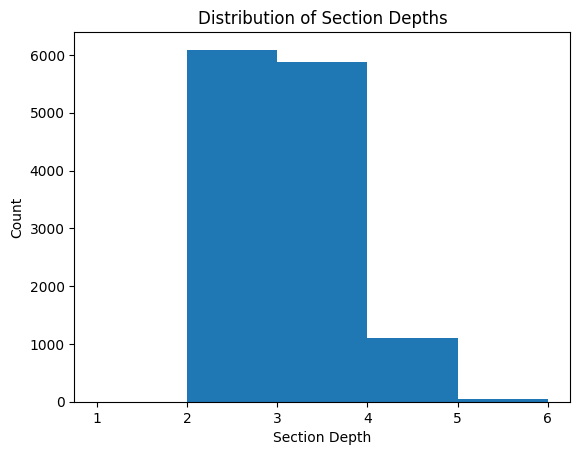

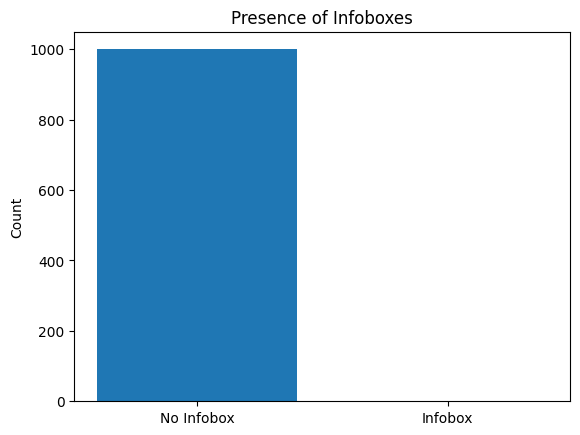

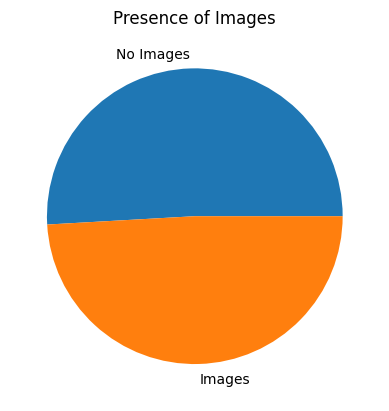

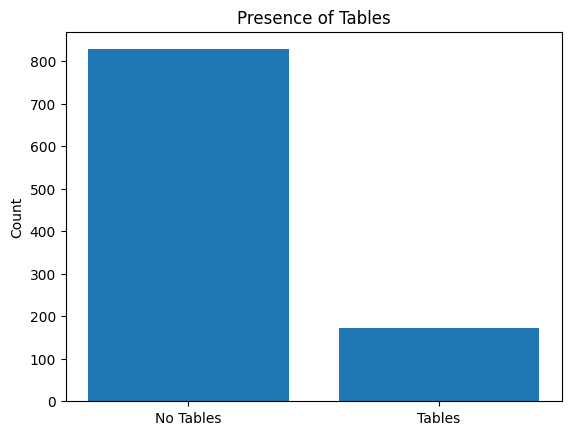

In [ ]:
#Analyzing the structure of Wikipedia articles
import matplotlib.pyplot as plt
import numpy as np

# Create a list of article structures
article_structures = [analyze_article_structure(article) for article in articles]

# Extract the data for each visualization
section_depths = [depth for _, depths, _, _, _ in article_structures for depth in depths]
infoboxes = [infobox for _, _, infobox, _, _ in article_structures]
images = [image for _, _, _, image, _ in article_structures]
tables = [table for _, _, _, _, table in article_structures]

# Section Depth Distribution
plt.hist(section_depths, bins=np.arange(1, max(section_depths)+2))
plt.xlabel('Section Depth')
plt.ylabel('Count')
plt.title('Distribution of Section Depths')
plt.show()

# Presence of Infoboxes
labels = ['No Infobox', 'Infobox']
values = [infoboxes.count(False), infoboxes.count(True)]
plt.bar(labels, values)
plt.ylabel('Count')
plt.title('Presence of Infoboxes')
plt.show()

# Presence of Images
labels = ['No Images', 'Images']
values = [images.count(False), images.count(True)]
plt.pie(values, labels=labels)
plt.title('Presence of Images')
plt.show()

# Presence of Tables
labels = ['No Tables', 'Tables']
values = [tables.count(False), tables.count(True)]
plt.bar(labels, values)
plt.ylabel('Count')
plt.title('Presence of Tables')
plt.show()

In [ ]:
# Most frequently linked pages within Wikipedia articles
import re
from collections import Counter

# Extract all internal links from the articles
internal_links = []
for article in articles:
    wikicode = mwparserfromhell.parse(article[1])
    links = [link.title.strip_code().replace('_', ' ') for link in wikicode.filter_wikilinks()]
    internal_links.extend(links)

# Filter out non-article links (e.g. links to templates, categories, etc.)
article_link_pattern = re.compile(r'^([^\W\d_]+:){0,1}[^\W\d_]+$', re.UNICODE)
internal_links = [link for link in internal_links if article_link_pattern.match(link)]

# Get the most frequently linked pages
most_linked_pages = Counter(internal_links).most_common(10)

# Print the results
for page, count in most_linked_pages:
    print(f"{page}: {count} links")

NASA: 93 links
Latin: 76 links
Iliad: 70 links
Turkey: 67 links
Plutarch: 66 links
Homer: 65 links
Baku: 64 links
Aristotle: 63 links
Rome: 62 links
Routledge: 56 links


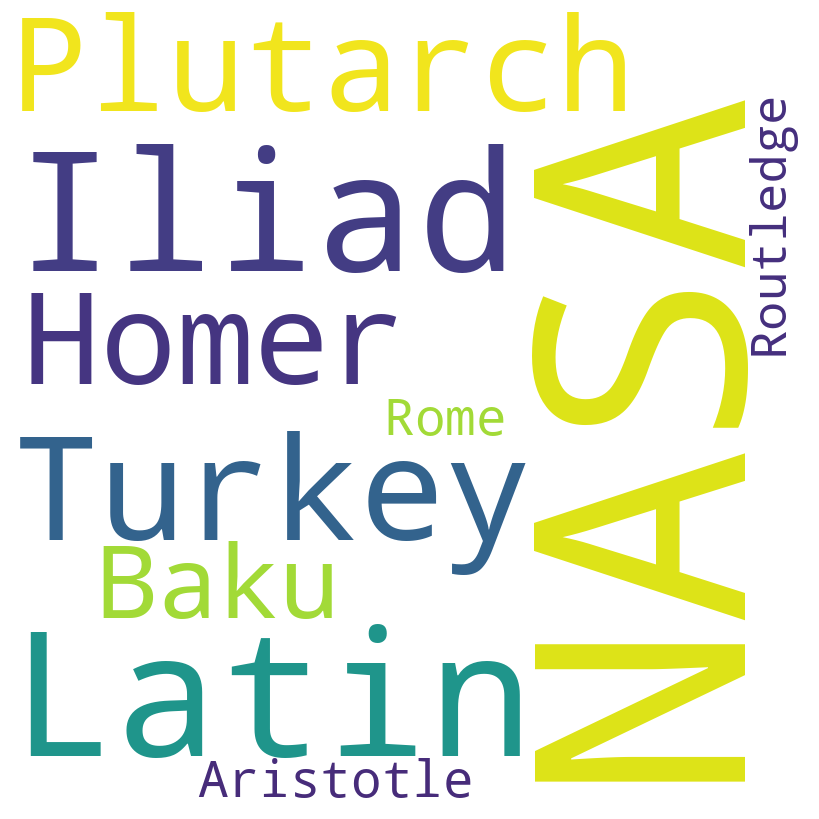

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary of word frequencies
word_frequencies = dict(most_linked_pages)

# Generate a word cloud from the word frequencies
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_frequencies)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
!pip install py7zr

In [ ]:
import py7zr
filename = '/content/drive/MyDrive/meta-history1.xml-p1p857.7z'
with py7zr.SevenZipFile(filename, 'r') as archive:
  archive.extractall('content/drive/MyDrive/meta-history1.xml-p1p857')

In [ ]:
#Temporal Analysis
import xml.etree.ElementTree as ET
from datetime import datetime
import random

# Set up a dictionary to keep track of revision counts by article and date
revision_counts = {}

# Set the maximum file size to process
max_file_size = 7 * 1024 * 1024 * 1024

# Initialize a counter for the processed file size
processed_file_size = 0

# Create a generator for parsing the XML file
context = ET.iterparse('/content/content/drive/MyDrive/meta-history1.xml-p1p857/meta-history1.xml-p1p857', events=('start', 'end'))

# Get the root element
_, root = next(context)

# Loop over all the elements in the XML
for event, elem in context:
    if event == 'end' and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}page':
        # Get the title of the article
        title = elem.find('{http://www.mediawiki.org/xml/export-0.10/}title').text

        # Initialize the revision counts for this article
        revision_counts[title] = {}

        # Loop over all the <revision> elements for this article
        for revision in elem.findall('{http://www.mediawiki.org/xml/export-0.10/}revision'):
            # Get the timestamp of the revision
            timestamp_str = revision.find('{http://www.mediawiki.org/xml/export-0.10/}timestamp').text

            # Parse the timestamp string into a datetime object
            timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%SZ')

            # Extract the year and month from the datetime object
            year = timestamp.year
            month = timestamp.month

            # Add the revision to the counts for this article and date
            if year not in revision_counts[title]:
                revision_counts[title][year] = {}
            if month not in revision_counts[title][year]:
                revision_counts[title][year][month] = 0
            revision_counts[title][year][month] += 1

        # Update the processed file size
        processed_file_size += len(ET.tostring(elem))

        # Clear the element to free memory
        elem.clear()

        # Stop parsing if the processed file size exceeds the limit
        if processed_file_size >= max_file_size:
            break

# Check if there are any articles in the processed data
if len(revision_counts) > 0:
    # Select a random article title
    random_title = random.choice(list(revision_counts.keys()))

    # Print the revision counts for the random article
    print(f"Revision counts for '{random_title}':")
    print(revision_counts[random_title])
else:
    print("No articles were found in the processed data.")

Revision counts for 'ArtificalLanguages':
{2002: {2: 1, 4: 1}, 2001: {9: 1}, 2006: {2: 1, 9: 1}, 2014: {3: 3, 9: 1}, 2017: {3: 1}, 2019: {1: 1, 5: 1}}


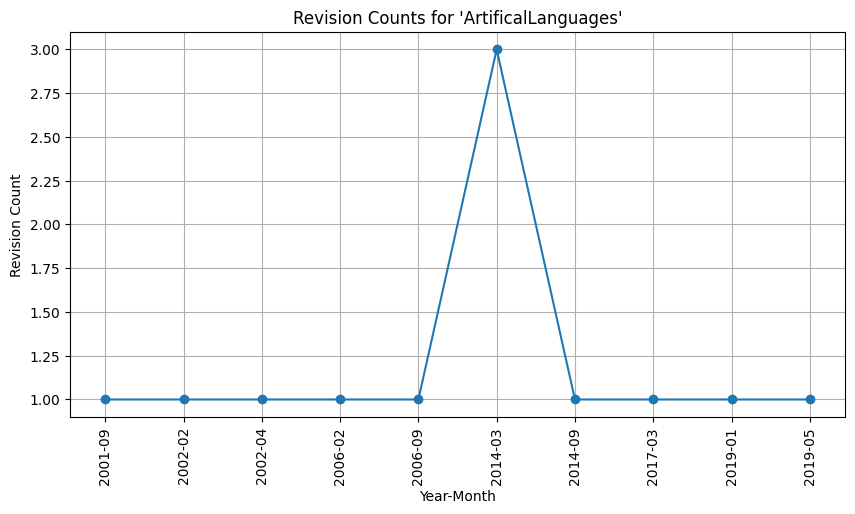

Revision counts for 'AnarchoCapitalism':
{2001: {2: 2}, 2002: {2: 1}, 2007: {9: 1}, 2017: {6: 1}}


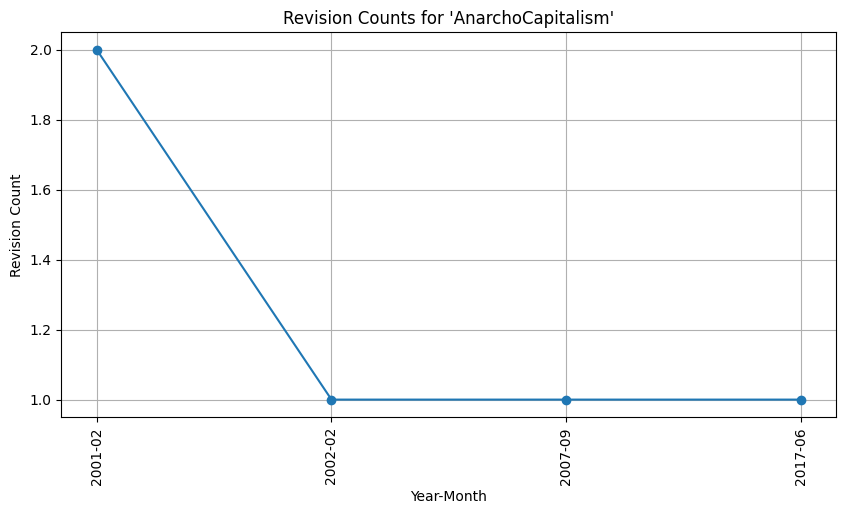

Revision counts for 'AfghanistanTransnationalIssues':
{2001: {1: 1}, 2002: {2: 1, 10: 1}, 2006: {4: 1}, 2017: {6: 1}}


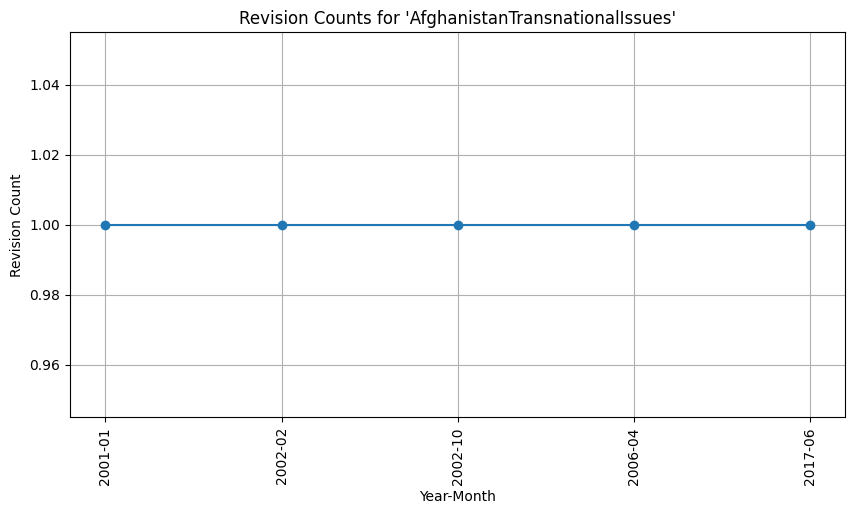

Revision counts for 'AbbadideS':
{2001: {3: 1}, 2002: {2: 1, 10: 1}, 2006: {4: 1}, 2012: {7: 1}, 2017: {6: 1}}


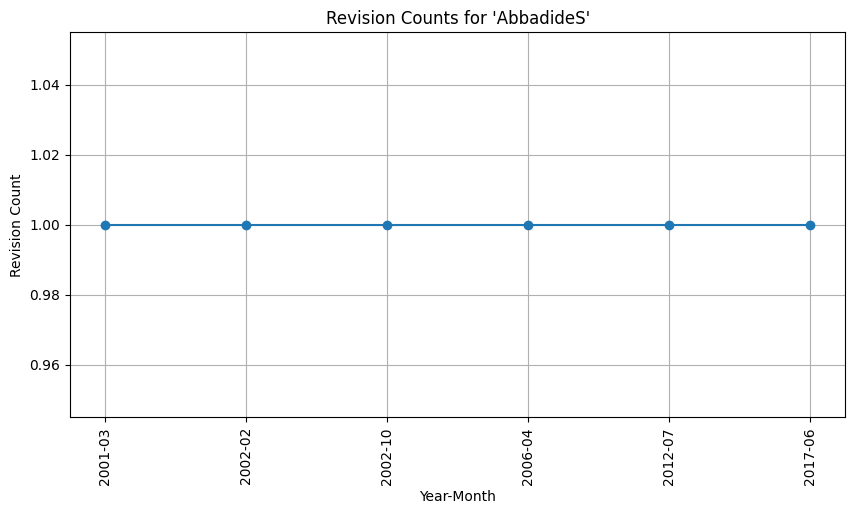

Revision counts for 'AndorrA':
{2001: {2: 1}, 2002: {2: 1}, 2007: {2: 1}, 2017: {6: 1}}


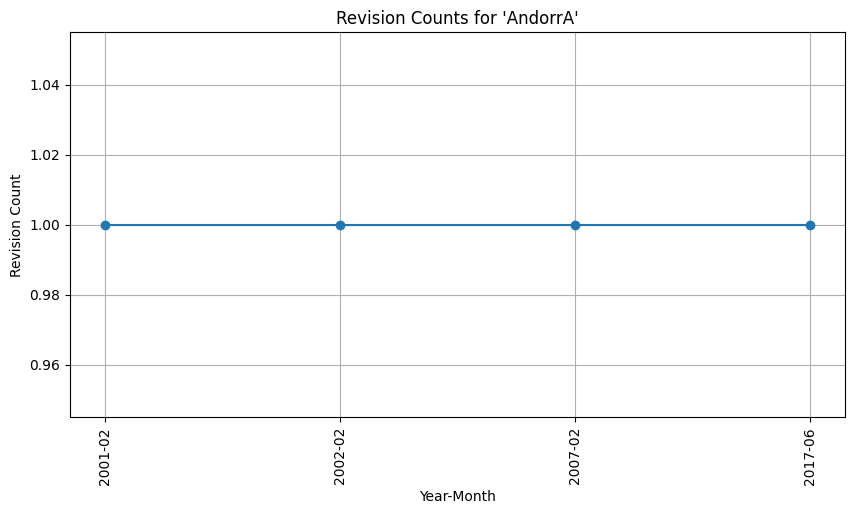

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_revision_counts(title, revision_data):
    years = []
    month_counts = []
    for year, months in sorted(revision_data.items()):
        for month, count in sorted(months.items()):
            years.append(f"{year}-{month:02d}")
            month_counts.append(count)

    plt.figure(figsize=(10, 5))
    plt.plot(years, month_counts, marker='o', linestyle='-')
    plt.xlabel('Year-Month')
    plt.ylabel('Revision Count')
    plt.title(f"Revision Counts for '{title}'")
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

# Number of articles to display
num_articles = 5

# Check if there are enough articles in the processed data
if len(revision_counts) >= num_articles:
    # Select random article titles
    random_titles = random.sample(list(revision_counts.keys()), num_articles)

    # Print the revision counts and display the bar charts for the random articles
    for random_title in random_titles:
        print(f"Revision counts for '{random_title}':")
        print(revision_counts[random_title])
        plot_revision_counts(random_title, revision_counts[random_title])
else:
    print(f"Less than {num_articles} articles were found in the processed data.")

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, year, month, avg
import xml.etree.ElementTree as ET
from datetime import datetime
import random
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# Initialize the Spark session
spark = SparkSession.builder.master("local[*]").appName("WikipediaAnalysis").getOrCreate()

# Set the maximum file size to process (1GB)
max_file_size = 1 * 1024 * 1024 * 1024

# Initialize a counter for the processed file size
processed_file_size = 0

# Create a generator for parsing the XML file
context = ET.iterparse('/content/content/drive/MyDrive/meta-history1.xml-p1p857/meta-history1.xml-p1p857', events=('start', 'end'))

# Get the root element
_, root = next(context)

# Initialize an empty list to store the revision data
revision_data = []

# Loop over all the elements in the XML
for event, elem in context:
    if event == 'end' and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}page':
        # Loop over all the <revision> elements for this article
        for revision in elem.findall('{http://www.mediawiki.org/xml/export-0.10/}revision'):
            # Get the username and timestamp of the revision
            contributor = revision.find('{http://www.mediawiki.org/xml/export-0.10/}contributor')
            username = contributor.find('{http://www.mediawiki.org/xml/export-0.10/}username')
            if username is not None:
                username = username.text
                timestamp_str = revision.find('{http://www.mediawiki.org/xml/export-0.10/}timestamp').text

                # Add the revision data to the list
                revision_data.append((username, timestamp_str))

        # Update the processed file size
        processed_file_size += len(ET.tostring(elem))

        # Clear the element to free memory
        elem.clear()

        # Stop parsing if the processed file size exceeds the limit
        if processed_file_size >= max_file_size:
            break

# Convert the revision data to a Spark DataFrame
columns = ["username", "timestamp"]
revision_df = spark.createDataFrame(revision_data, columns)

# Add the year and month columns
revision_df = revision_df.withColumn("year", year("timestamp")).withColumn("month", month("timestamp"))

# Calculate the total number of revisions per year
revisions_per_year = revision_df.groupBy("year").agg(count("*").alias("total_revisions"))

# Display the total number of revisions per year
revisions_per_year.sort("year").show()

# Find the top contributors for each year
window_spec = Window.partitionBy("year").orderBy(col("revision_count").desc())
top_contributors_per_year = revision_df.groupBy("year", "username").agg(count("*").alias("revision_count")) \
    .withColumn("rank", row_number().over(window_spec)) \
    .filter(col("rank") <= 3)

# Display the top contributors for each year
top_contributors_per_year.sort("year", "rank").show()

# Calculate the average monthly revisions for each user
average_monthly_revisions = revision_df.groupBy("username", "year", "month").agg(count("*").alias("monthly_revisions"))

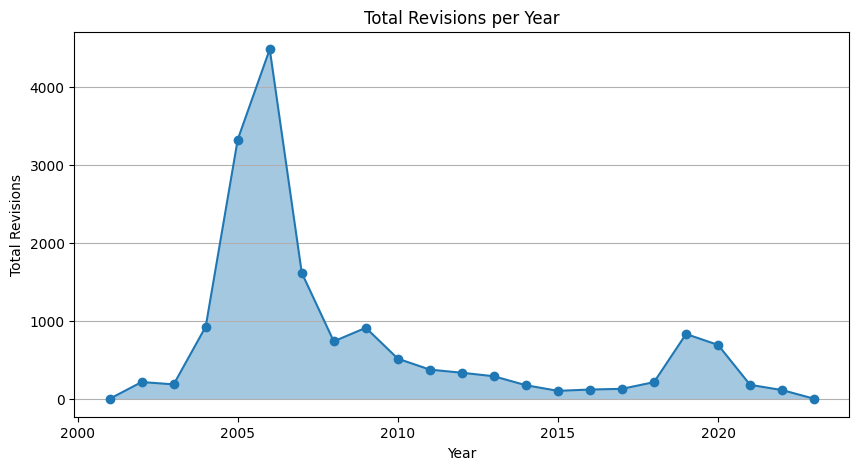

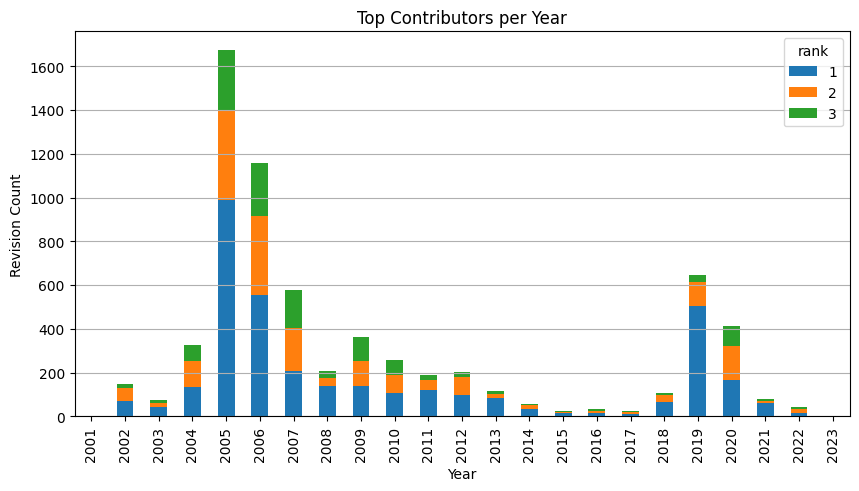

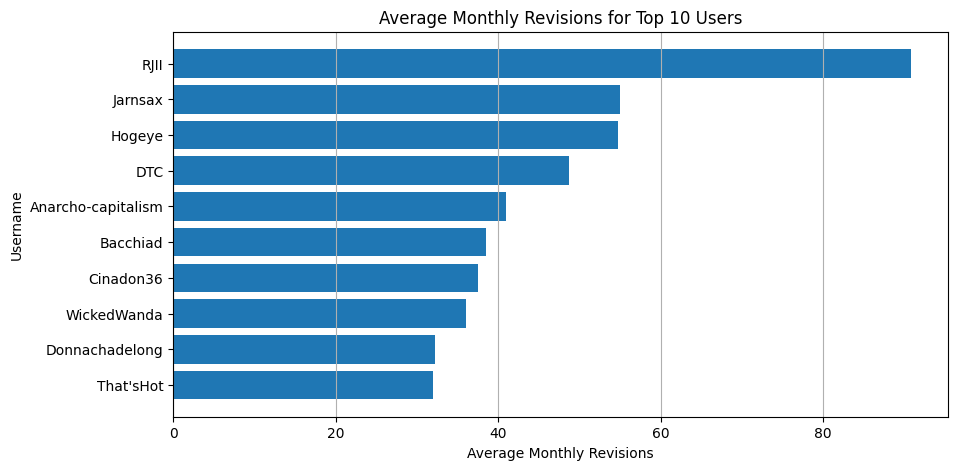

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the total revisions per year to a Pandas DataFrame
#revisions_per_year_pd = revisions_per_year.toPandas().sort_values('year')

# Area chart for total revisions per year
plt.figure(figsize=(10, 5))
plt.fill_between(revisions_per_year_pd['year'], revisions_per_year_pd['total_revisions'], alpha=0.4)
plt.plot(revisions_per_year_pd['year'], revisions_per_year_pd['total_revisions'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Revisions')
plt.title('Total Revisions per Year')
plt.grid(axis='y')
plt.show()

# Stacked bar chart for the top contributors per year
contributors_pivot = top_contributors_per_year_pd.pivot_table(index='year', columns='rank', values='revision_count')
contributors_pivot.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.xlabel('Year')
plt.ylabel('Revision Count')
plt.title('Top Contributors per Year')
plt.grid(axis='y')
plt.show()

# Horizontal bar chart for the average monthly revisions of the top 10 users
plt.figure(figsize=(10, 5))
plt.barh(top_users_by_monthly_revisions_pd['username'], top_users_by_monthly_revisions_pd['average_monthly_revisions'])
plt.ylabel('Username')
plt.xlabel('Average Monthly Revisions')
plt.title('Average Monthly Revisions for Top 10 Users')
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

# Stop the Spark session
spark.stop()

In [ ]:
!bunzip2 '/content/drive/MyDrive/simplewiki-latest-pages-articles.xml.bz2'

In [ ]:
!pip install lxml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


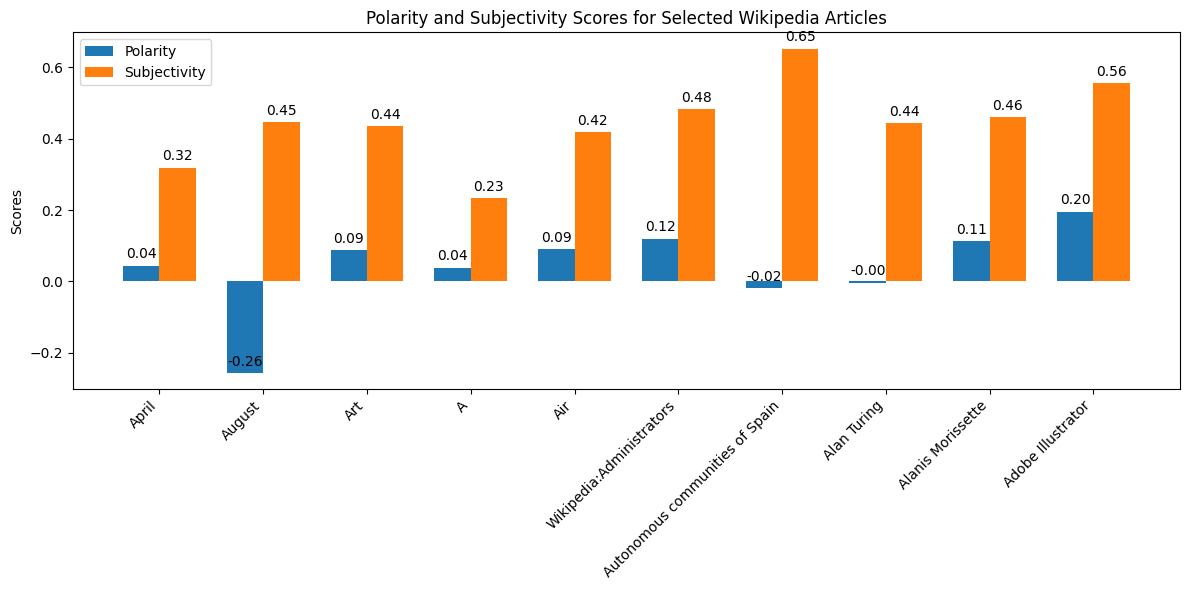

In [ ]:
# Sentiment Analysis
import dask.bag as db
from dask.diagnostics import ProgressBar
from textblob import TextBlob
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np

def extract_title_and_text(xml):
    root = etree.fromstring(xml)
    title = root.find(".//{http://www.mediawiki.org/xml/export-0.10/}title")
    text = root.find(".//{http://www.mediawiki.org/xml/export-0.10/}text")
    if title is not None and title.text is not None and text is not None and text.text is not None:
        return title.text, text.text
    return None, ""

def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def iter_pages(file, tag='{http://www.mediawiki.org/xml/export-0.10/}page'):
    context = etree.iterparse(file, events=('end',), tag=tag)
    for _, elem in context:
        yield etree.tostring(elem)
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]

xml_file = "/content/drive/MyDrive/simplewiki-latest-pages-articles.xml"
sentiment_scores = []

with open(xml_file, 'rb') as f:
    xml_parts = list(iter_pages(f))

bag = db.from_sequence(xml_parts)
title_text_pairs = bag.map(extract_title_and_text).filter(lambda x: x[0] is not None and x[1] != "").compute()

sentiment_scores = [(title, *sentiment_analysis(text)) for title, text in title_text_pairs]

# Extract titles and scores
titles = [title for title, _, _ in sentiment_scores[:10]]
polarity_scores = [polarity for _, polarity, _ in sentiment_scores[:10]]
subjectivity_scores = [subjectivity for _, _, subjectivity in sentiment_scores[:10]]

# Plot the bar chart
ind = np.arange(len(titles))  # x locations for the groups
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(ind - width/2, polarity_scores, width, label="Polarity")
rects2 = ax.bar(ind + width/2, subjectivity_scores, width, label="Subjectivity")

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel("Scores")
ax.set_title("Polarity and Subjectivity Scores for Selected Wikipedia Articles")
ax.set_xticks(ind)
ax.set_xticklabels(titles, rotation=45, ha="right")
ax.legend()

# Create a function to attach a label on each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.2f}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha="center", va="bottom")

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Calculate the average sentiment polarity and subjectivity scores
avg_polarity = sum(polarity for _, polarity, _ in sentiment_scores) / len(sentiment_scores)
avg_subjectivity = sum(subjectivity for _, _, subjectivity in sentiment_scores) / len(sentiment_scores)

In [ ]:
import py7zr
filename = '/content/drive/MyDrive/20230201-pages-meta-history1.xml-p1p857.7z'
with py7zr.SevenZipFile(filename, 'r') as archive:
  archive.extractall('/content/drive/MyDrive/20230201-pages-meta-history1.xml-p1p857')

In [ ]:
!pip install pyspark

In [ ]:
#Sankey Diagram
!pip install plotly
import plotly.graph_objects as go

# Limit the number of paths for visualization
top_paths = navigation_paths.limit(50).toPandas()
top_paths = top_paths.sort_values(by='count', ascending=False)
top_paths.reset_index(drop=True, inplace=True)

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5),
              label=top_paths['referrer'].tolist() + top_paths['requested_page'].tolist()),
    link=dict(source=top_paths.index, target=top_paths.index + len(top_paths),
              value=top_paths['count'])
)])

fig.update_layout(
    title_text="Sankey diagram Wikipedia User Navigation Patterns",
    font_size=10,  # Adjust the font size of the labels
    height=800,    # Set the height of the plot
    width=1200,    # Set the width of the plot
)
fig.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md

In [ ]:
!pip install wikipedia-api

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
pip install sentence-transformers

In [ ]:
import pandas as pd

# Define a list of top Wikipedia pages
top_page_titles = [
    'Meghan_Markle',
    'Justice_League_(film)',
    'Stranger_Things',
    'Charles_Manson',
    'Thor:_Ragnarok',
    'Deaths_in_2017',
    'Lil_Peep'
]

# Create a DataFrame and use the .index attribute
top_pages = pd.DataFrame(top_page_titles, columns=['title']).set_index('title')

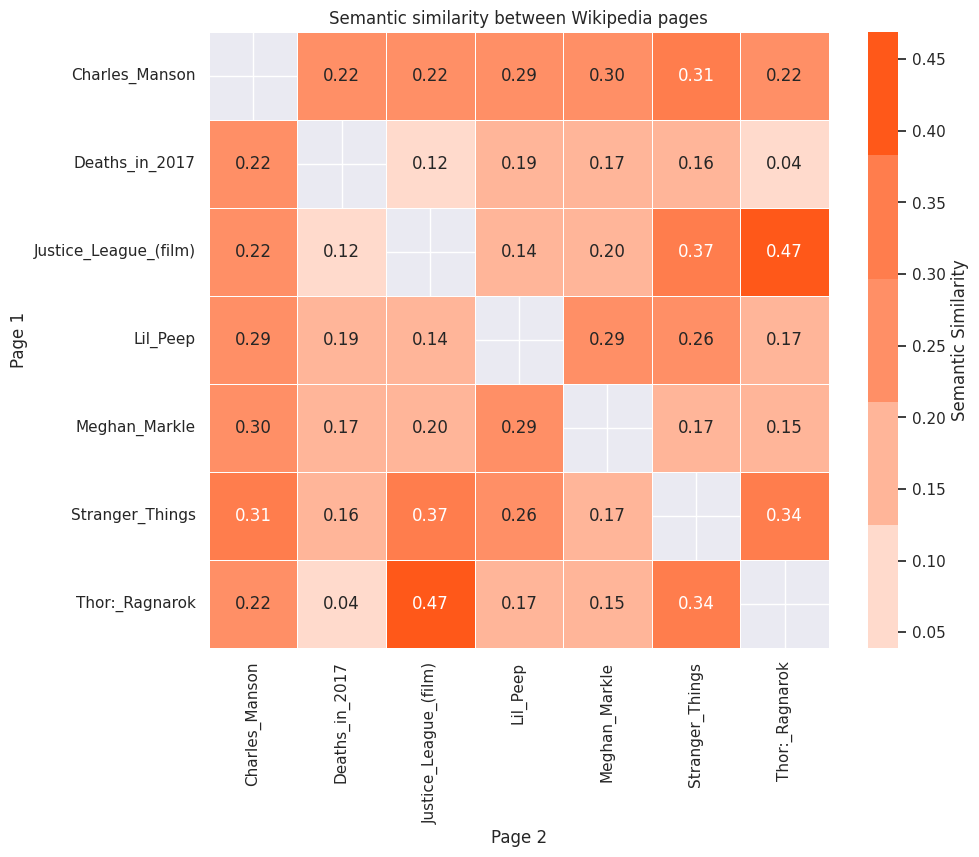

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sentence_transformers import SentenceTransformer
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')

# Load a pre-trained sentence transformer model
model = SentenceTransformer("paraphrase-mpnet-base-v2")

# Define a function to fetch the content of a Wikipedia page
def fetch_page_content(page_title):
    try:
        page = wiki_wiki.page(page_title)
        if page.exists():
            return page.text
        else:
            return None
    except wikipediaapi.exceptions.RequestException as e:
        print(f"Error fetching content for '{page_title}': {e}")
        return None

# Fetch the content of the top N Wikipedia pages
top_page_contents = {}
for page_title in top_pages.index:
    content = fetch_page_content(page_title)
    if content:
        top_page_contents[page_title] = model.encode(content)

# Calculate semantic similarity between pairs of top pages
similarity_matrix = {}
for title1, emb1 in top_page_contents.items():
    for title2, emb2 in top_page_contents.items():
        if title1 != title2:
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similarity_matrix[(title1, title2)] = similarity

# Create a DataFrame with the similarity data
similarity_data = [
    {"Page 1": pair[0], "Page 2": pair[1], "Similarity": similarity}
    for pair, similarity in filtered_similarity_matrix.items()
]
similarity_df = pd.DataFrame(similarity_data)

# Pivot the DataFrame to prepare for heatmap
heatmap_data = similarity_df.pivot_table(index="Page 1", columns="Page 2", values="Similarity")

# Define a custom colormap with warm colors
colors = ["#FFDACC", "#FFB599", "#FF8F66", "#FF7D4D", "#FF5819"]
cmap = ListedColormap(sns.color_palette(colors).as_hex())

# Plot the heatmap with the custom colormap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1)
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap=cmap,
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={"label": "Semantic Similarity"},
)
plt.title("Semantic similarity between Wikipedia pages")
plt.show()

# Print the semantic similarity scores
#print("Semantic similarity between top Wikipedia pages (using sentence-transformers):")
#for pair, similarity in similarity_matrix.items():
#    print(f"{pair[0]} - {pair[1]}: {similarity:.2f}")

In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

In [ ]:
!pip install holoviews bokeh

In [ ]:
!pip install panel

In [ ]:
import panel as pn

In [ ]:
import holoviews as hv
import numpy as np
import pandas as pd
hv.extension('bokeh')

In [ ]:
# Limit the data for visualization purposes
top_paths = navigation_paths.limit(50).toPandas()
top_paths = top_paths.sort_values(by='count', ascending=False)
top_paths.reset_index(drop=True, inplace=True)

# Create a list of unique page labels
labels = pd.unique(top_paths[['referrer', 'requested_page']].values.ravel('K'))

# Create a square matrix with the number of unique pages
n_pages = len(labels)
matrix = np.zeros((n_pages, n_pages))

# Fill the matrix with the number of clicks between the referrer and requested_page
for _, row in top_paths.iterrows():
    source = np.where(labels == row['referrer'])[0][0]
    target = np.where(labels == row['requested_page'])[0][0]
    matrix[source, target] = row['count']

# Normalize the matrix
normalized_matrix = matrix / matrix.max()

# Create a DataFrame for the chord diagram
chord_data = pd.DataFrame(normalized_matrix, columns=labels, index=labels).stack().reset_index()
chord_data.columns = ['source', 'target', 'value']
chord_data = chord_data[chord_data['value'] > 0]

# Remove rows containing None values
chord_data = chord_data.dropna()

# Create the chord diagram
chord = hv.Chord(chord_data).opts(
    title="Chord Diagram of Wikipedia User Navigation Patterns",
    node_color='index',
    cmap='Category20',
    width=800,
    height=800,
    labels='index',  # Add labels to the nodes
    edge_color='source'
)

# Convert the chord diagram to a Panel object
chord_panel = pn.panel(chord)

# Save the chord diagram as an HTML file
hv.save(chord_panel, 'chord_diagram.html')

from google.colab import files
files.download('chord_diagram.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>